In [72]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = ResNet50(
    weights=None,
    include_top=False,
input_shape=(32, 32, 1)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
preds = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False
    
# model.summary()

# Preprocess

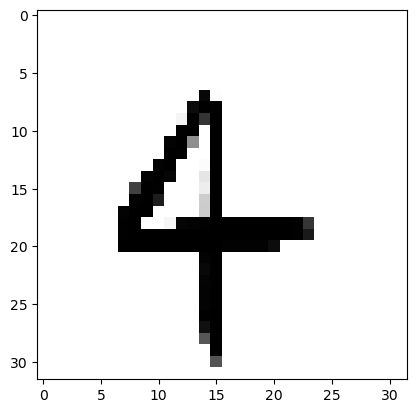

In [73]:
import matplotlib.pyplot as plt
import cv2 as cv

def preprocess_image(image_path):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (32, 32))
    img = img.astype('float32')
    img = img.reshape(1024, 1)
    img = 255-img
    img /= 255.0
    img = img.reshape(1,32,32,1)

    return img

image = preprocess_image('handwriting/4.png')  # 전처리된 이미지 얻기

plt.imshow(image.reshape(32, 32), cmap='Greys')
plt.show()

# Predict

In [74]:
import tensorflow as tf

@tf.function
def predict_image(model, image):
    return model(image)  # model.predict가 아니라 model(image)를 호출

pred = predict_image(model, image)  # 전처리된 이미지를 모델에 전달하여 예측
print(pred)
print(f'predicted number = {pred.numpy().argmax()}')

tf.Tensor(
[[0.10022581 0.10041957 0.10051839 0.09994617 0.09970164 0.09927037
  0.10084131 0.1003659  0.09975921 0.09895162]], shape=(1, 10), dtype=float32)
predicted number = 6
